# Notebook: zero- and one-shot object detection with OWLv2

In this notebook, we'll play around with [OWLv2](https://huggingface.co/docs/transformers/main/en/model_doc/owlv2), the scaled up version of Google's [OWL-ViT model](https://huggingface.co/docs/transformers/model_doc/owlvit). This model is a minimal modification of OpenAI's [CLIP](https://huggingface.co/docs/transformers/model_doc/clip) model to do zero-shot object detection (meaning, detecting objects in an image without every being trained explicitly with manually drawn bounding boxes). This is awesome since usually, for having a good object detector, one needs to collect a dataset of manually drawn bounding boxes, which is a very boring task!

## Set-up environment

Let's start by installing our favorite library: 🤗 Transformers. We install from Github here as the model is brand new at the time of writing.

In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 63.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 81.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 37.9 MB/s eta 0:00:00


## Load model and processor

Next, we load an OWLv2 checkpoint from the [hub](https://huggingface.co/models?other=owlv2). Note that the authors released several, with various patch sizes, and training schemes (self-trained only, self-trained + fine-tuned, and an ensemble). We'll load an ensemble checkpoint here since it performs best. Note that the authors also did release larger checkpoints, which have even better performance.

In [ ]:
device = 'cuda'

In [ ]:
from transformers import Owlv2Processor, Owlv2ForObjectDetection

processor = Owlv2Processor.from_pretrained("google/owlv2-base-patch16-ensemble")
model = Owlv2ForObjectDetection.from_pretrained("google/owlv2-base-patch16-ensemble")
model = model.to(device)

## Load image

Next, let's load an image on which we'd like to detect some objects. Here we load our familiar cats image.

In [ ]:
import cv2
import os

import numpy as np
from transformers.utils.constants import OPENAI_CLIP_MEAN, OPENAI_CLIP_STD
import torch
from PIL import Image
import tqdm

In [ ]:



def get_preprocessed_image(pixel_values):
    pixel_values = pixel_values.squeeze().numpy()
    unnormalized_image = (pixel_values * np.array(OPENAI_CLIP_STD)[:, None, None]) + np.array(OPENAI_CLIP_MEAN)[:, None, None]
    unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
    unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
    unnormalized_image = Image.fromarray(unnormalized_image)
    return unnormalized_image

def run_model(frame, text):
    # Process the frame with your model
    # Replace this with your actual model code
    image= Image.fromarray(frame)

    inputs = processor(text=text, images=image, return_tensors="pt")
    unnormalized_image = get_preprocessed_image(inputs.pixel_values)
    inputs = inputs.to(device)
    with torch.no_grad():
      outputs = model(**inputs)

    # Convert outputs (bounding boxes and class logits) to COCO API
    target_sizes = torch.Tensor([unnormalized_image.size[::-1]]).to(device)
    results = processor.post_process_object_detection(outputs=outputs, target_sizes=target_sizes, threshold=0.2)
    i = 0  # Retrieve predictions for the first image for the corresponding text queries
    text = texts[i]
    boxes, scores, labels = results[i]["boxes"], results[i]["scores"], results[i]["labels"]

    annotations = []

    for box, score, label in zip(boxes, scores, labels):
        box = [round(i, 2) for i in box.tolist()]

        # Convert box coordinates to YOLO format
        class_index = label.item()
        x_center, y_center, width, height = box[0] + box[2] / 2, box[1] + box[3] / 2, box[2], box[3]
        annotations.append(f"{class_index} {x_center} {y_center} {width} {height}")

    return annotations

In [ ]:

# Read video from file

video_file = '/content/drive/MyDrive/BU_fall23/sparkml/project/videos/AXON_Body_2_Video_2020-05-31_2055-002.mp4'


In [ ]:
annotation_path = '/content/drive/MyDrive/BU_fall23/sparkml/project/video_annotation'
video_annotation_path = os.path.join(annotation_path,video_file.split('/')[-1])
os.makedirs(video_annotation_path,exist_ok=True)
annotation_path = os.path.join(video_annotation_path,'annotation')
frame_path = os.path.join(video_annotation_path,'frame')
os.makedirs(annotation_path,exist_ok=True)
os.makedirs(frame_path,exist_ok=True)


In [ ]:


texts = [['a cop', 'police baton', 'stick', 'protestors','pepper spray','bottle']]

frame_count = 0

cap = cv2.VideoCapture(video_file)

total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

pbar = tqdm.tqdm_notebook(total=total_frames, desc='Processing Frames')

fps = int(cap.get(cv2.CAP_PROP_FPS))


while True:
    ret, frame = cap.read()

    if not ret:
        break

    if frame_count % fps == 0:
        annotations = run_model(frame, texts)

        # Save annotations to a YOLO format text file
        with open(f'{annotation_path}/frame{frame_count:04d}.txt', 'w') as file:
            file.write('\n'.join(annotations))

        # Save the frame as an image
        cv2.imwrite(f'{frame_path}/frame{frame_count:04d}.jpg', frame)

    frame_count += 1
    pbar.update(1)


cap.release()
pbar.close()


<ipython-input-67-0a450c34f4c5>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar = tqdm.tqdm_notebook(total=total_frames, desc='Processing Frames')


Processing Frames:   0%|          | 0/251370 [00:00<?, ?it/s]

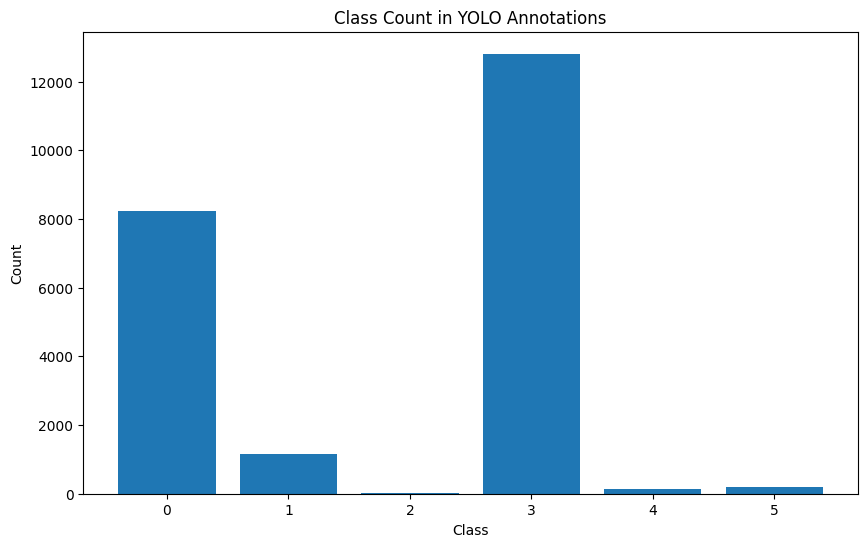

In [3]:
import os
import matplotlib.pyplot as plt

def count_classes_in_folder(folder_path):
    class_count = {}
    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"):
            with open(os.path.join(folder_path, filename), 'r') as file:
                lines = file.readlines()
                for line in lines:
                    class_id = int(line.split()[0])
                    if class_id not in class_count:
                        class_count[class_id] = 1
                    else:
                        class_count[class_id] += 1
    return class_count

def plot_class_count(class_count):
    classes = list(class_count.keys())
    counts = list(class_count.values())

    plt.figure(figsize=(10, 6))
    plt.bar(classes, counts)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title('Class Count in YOLO Annotations')
    plt.show()

[['a cop', 'police baton', 'stick', 'protestors','pepper spray','bottle']
# Replace 'path_to_yolo_annotations_folder' with the actual path to your folder
yolo_folder_path = '/content/drive/MyDrive/BU_fall23/sparkml/project/video_annotation/AXON_Body_2_Video_2020-05-31_2055-002.mp4/annotation/'
class_count = count_classes_in_folder(yolo_folder_path)
plot_class_count(class_count)


In [1]:
print(count)

NameError: ignored

## Normal Inference

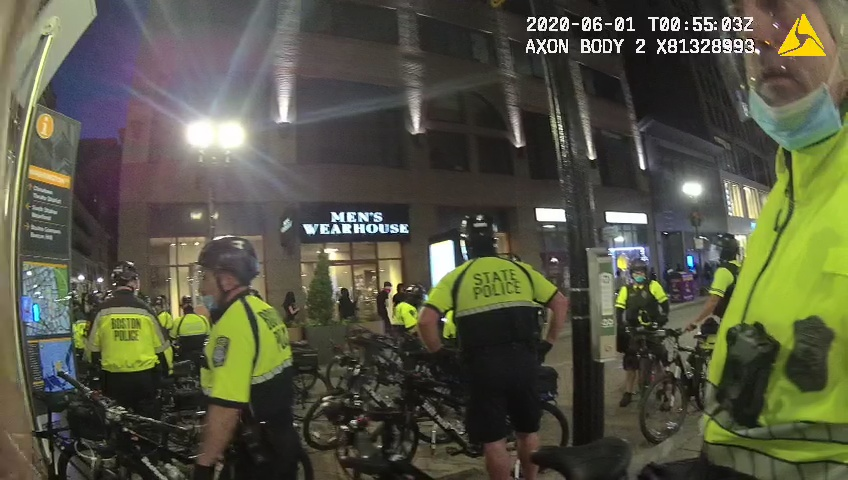

In [ ]:
from PIL import Image
import requests


image = Image.open('/content/drive/MyDrive/BU_fall23/sparkml/project/video_annotation/AXON_Body_2_Video_2020-05-31_2055-002.mp4/frame/frame0000.jpg').convert("RGB")
image

## Prepare image and queries for the model

OWLv2 (which uses the same architecture as OWL-ViT) is capable of detecting objects given text queries. Hence we'll define some texts which the model can detect. We can prepare the image and the texts for the model using the processor:

In [ ]:
texts = [['a cop', 'police baton', 'stick', 'protestors']]
inputs = processor(text=texts, images=image, return_tensors="pt")
for k,v in inputs.items():
  print(k,v.shape)

input_ids torch.Size([4, 16])
attention_mask torch.Size([4, 16])
pixel_values torch.Size([1, 3, 960, 960])


In [ ]:
inputs = inputs.to('cuda')

## Forward pass

Forwarding the inputs through the model is just a single line of code! We'll also use the `with torch_no_grad()` context manager here to reduce memory (we don't need gradients to be computed/stored at inference time).

In [ ]:
import torch

with torch.no_grad():
  outputs = model(**inputs)

## Visualize results

Finally let's plot the results! Important to note here is that the authors visualize the bounding boxes on the preprocessed (padded + resized) image, rather than the original one. Hence here we'll take the `pixel_values` created by the processor and "unnormalize" them. This gives us the preprocessed image, minus normalization.

As can be seen, the preprocessed image is an image that pads the original one to a square.

In [ ]:
inputs.pixel_values.cpu()

tensor([[[[ 0.2661,  0.2661,  0.2661,  ..., -0.2969, -0.4383, -0.5140],
          [ 0.2661,  0.2661,  0.2661,  ..., -0.1178, -0.2514, -0.2928],
          [ 0.2765,  0.2765,  0.2691,  ..., -0.0326, -0.1552, -0.1808],
          ...,
          [ 0.0690,  0.0690,  0.0690,  ...,  0.0690,  0.0690,  0.0690],
          [ 0.0690,  0.0690,  0.0690,  ...,  0.0690,  0.0690,  0.0690],
          [ 0.0690,  0.0690,  0.0690,  ...,  0.0690,  0.0690,  0.0690]],

         [[ 0.2289,  0.2289,  0.2289,  ..., -0.2298, -0.3751, -0.4530],
          [ 0.2289,  0.2289,  0.2289,  ..., -0.0457, -0.1830, -0.2256],
          [ 0.2396,  0.2396,  0.2320,  ...,  0.0419, -0.0841, -0.1105],
          ...,
          [ 0.1614,  0.1614,  0.1614,  ...,  0.1614,  0.1614,  0.1614],
          [ 0.1614,  0.1614,  0.1614,  ...,  0.1614,  0.1614,  0.1614],
          [ 0.1614,  0.1614,  0.1614,  ...,  0.1614,  0.1614,  0.1614]],

         [[-0.0156, -0.0156, -0.0156,  ..., -0.2938, -0.4315, -0.5053],
          [-0.0156, -0.0156, -

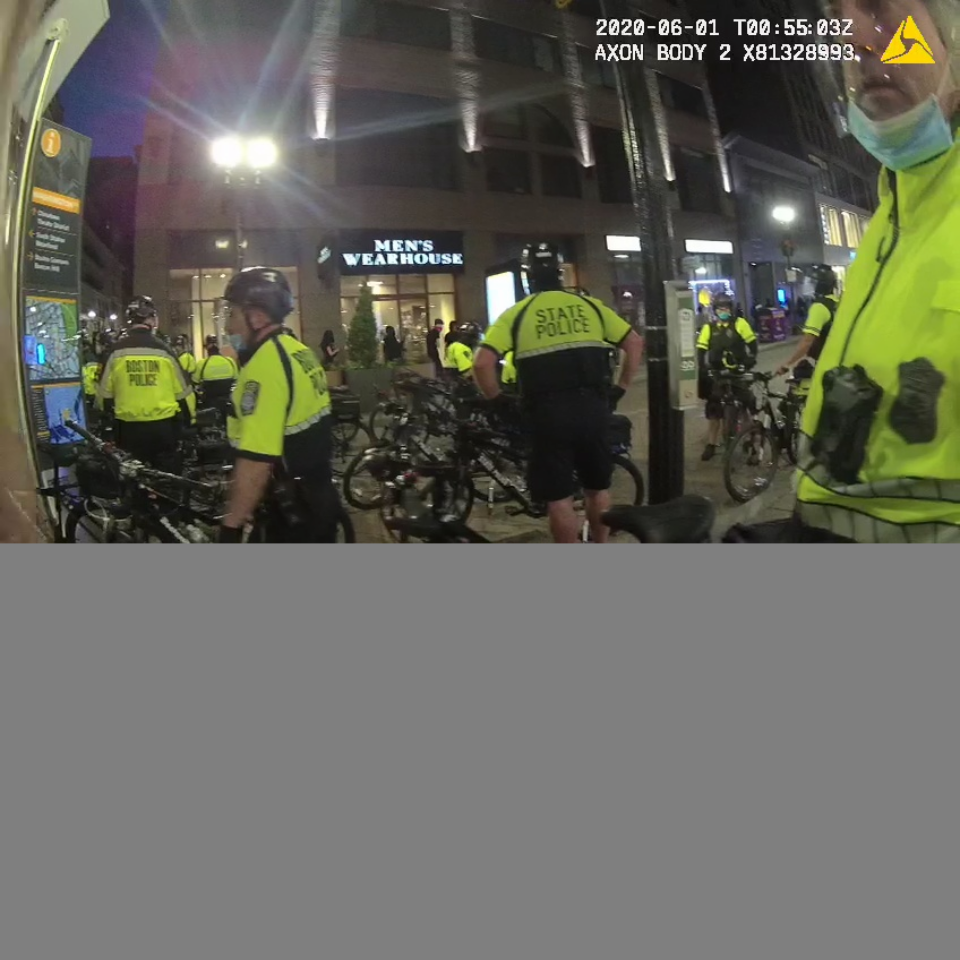

In [ ]:
import numpy as np
from transformers.utils.constants import OPENAI_CLIP_MEAN, OPENAI_CLIP_STD

def get_preprocessed_image(pixel_values):
    pixel_values = pixel_values.squeeze().numpy()
    unnormalized_image = (pixel_values * np.array(OPENAI_CLIP_STD)[:, None, None]) + np.array(OPENAI_CLIP_MEAN)[:, None, None]
    unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
    unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
    unnormalized_image = Image.fromarray(unnormalized_image)
    return unnormalized_image

unnormalized_image = get_preprocessed_image(inputs.pixel_values.cpu())
unnormalized_image

Finally we can visualize the boxes on top of this image.

In [ ]:
target_sizes.to('cuda')

tensor([[960., 960.]], device='cuda:0')

In [ ]:
# Convert outputs (bounding boxes and class logits) to COCO API
target_sizes = torch.Tensor([unnormalized_image.size[::-1]]).to('cuda')
results = processor.post_process_object_detection(outputs=outputs, target_sizes=target_sizes, threshold=0.2)
i = 0  # Retrieve predictions for the first image for the corresponding text queries
text = texts[i]
boxes, scores, labels = results[i]["boxes"], results[i]["scores"], results[i]["labels"]
for box, score, label in zip(boxes, scores, labels):
    box = [round(i, 2) for i in box.tolist()]
    print(f"Detected {text[label]} with confidence {round(score.item(), 3)} at location {box}")

Detected a cop with confidence 0.222 at location [784.79, 262.71, 840.57, 388.49]
Detected a cop with confidence 0.271 at location [727.26, 1.9, 962.51, 546.73]
Detected a cop with confidence 0.2 at location [440.32, 321.18, 481.02, 385.58]
Detected a cop with confidence 0.26 at location [97.18, 294.96, 197.58, 481.09]
Detected a cop with confidence 0.25 at location [213.8, 265.26, 338.27, 544.08]
Detected a cop with confidence 0.221 at location [471.86, 253.07, 641.0, 544.55]


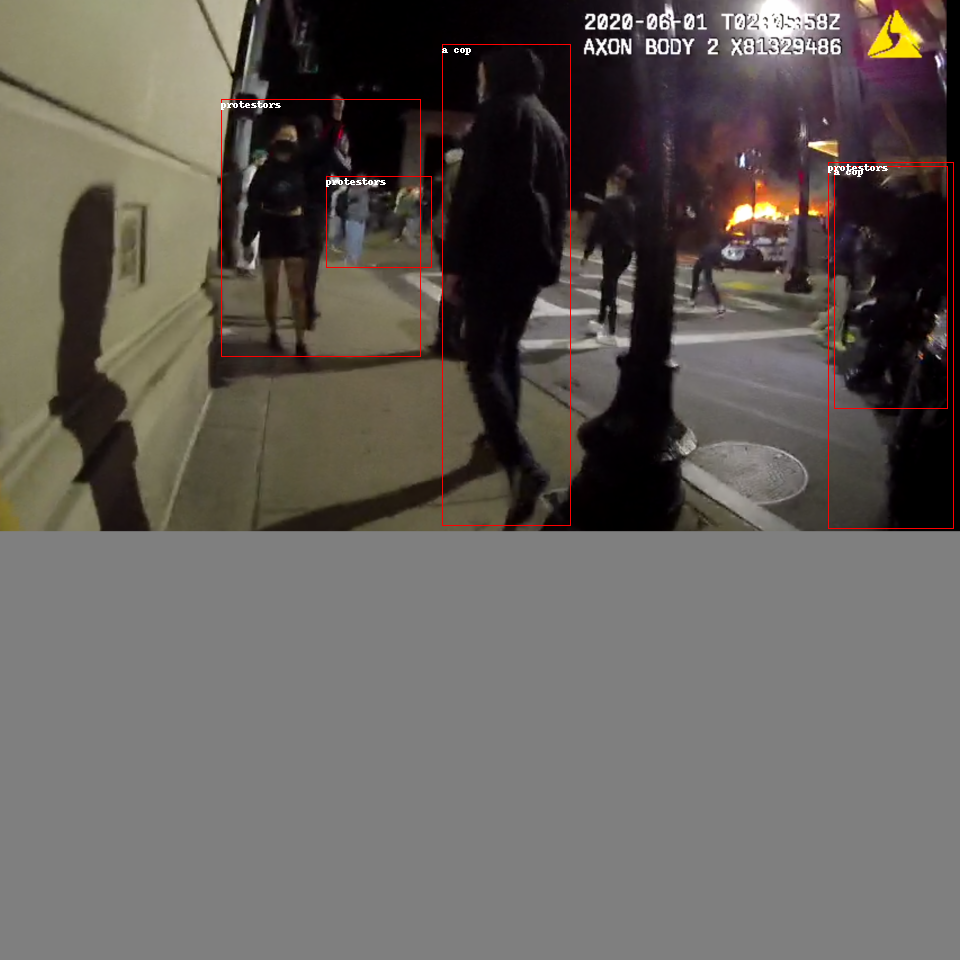

In [ ]:
from PIL import ImageDraw

visualized_image = unnormalized_image.copy()

draw = ImageDraw.Draw(visualized_image)

for box, score, label in zip(boxes, scores, labels):
    box = [round(i, 2) for i in box.tolist()]
    x1, y1, x2, y2 = tuple(box)
    draw.rectangle(xy=((x1, y1), (x2, y2)), outline="red")
    draw.text(xy=(x1, y1), text=text[label])

visualized_image

## Plot objectness

The OWLv2 models also include an objectness head, which predicts the (query-agnostic) likelihood that a predicted box contains an object (as opposed to background). The objectness score can be used to rank or filter predictions independently of text queries.

Text(0.5, 1.0, 'Top 20 objects by objectness')

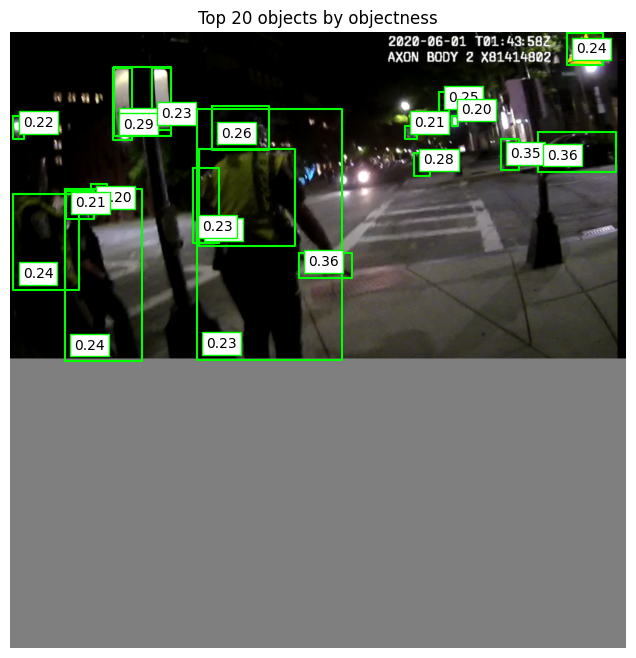

In [ ]:
from scipy.special import expit as sigmoid
import matplotlib.pyplot as plt

top_k = 20
objectnesses = sigmoid(outputs.objectness_logits.squeeze().numpy())
boxes = outputs.pred_boxes.squeeze().numpy()

objectness_threshold = np.partition(objectnesses, -top_k)[-top_k]

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(unnormalized_image, extent=(0, 1, 1, 0))
ax.set_axis_off()

for box, objectness in zip(boxes, objectnesses):
  if objectness < objectness_threshold:
    continue

  cx, cy, w, h = box
  ax.plot([cx - w / 2, cx + w / 2, cx + w / 2, cx - w / 2, cx - w / 2],
          [cy - h / 2, cy - h / 2, cy + h / 2, cy + h / 2, cy - h / 2],
          color='lime')

  ax.text(
    cx - w / 2 + 0.015,
    cy + h / 2 - 0.015,
    f'{objectness:1.2f}',
    ha='left',
    va='bottom',
    color='black',
    bbox={
        'facecolor': 'white',
        'edgecolor': 'lime',
        'boxstyle': 'square,pad=.3'
    })

ax.set_xlim(0, 1)
ax.set_ylim(1, 0)
ax.set_title(f'Top {top_k} objects by objectness')

# Image-conditioned detection

This section shows how to use objects detected in one image as queries on other images, instead of text strings.

Let's say we have a "source image", i.e. an image that contains a certain concept (like a cat), and we would like to detect this concept in another image, called the "target image".

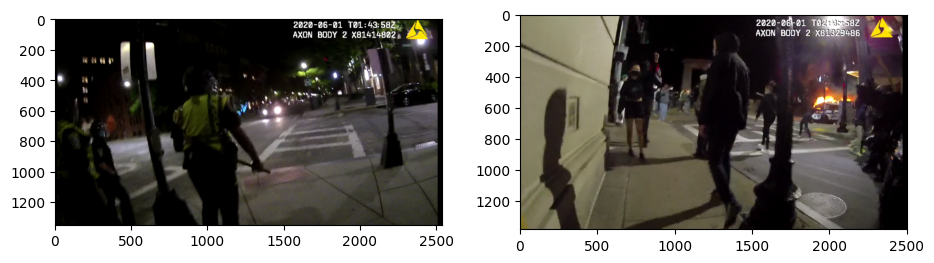

In [ ]:
import cv2
from PIL import Image
import requests
import torch
from matplotlib import rcParams
import matplotlib.pyplot as plt

# Set figure size
%matplotlib inline
rcParams['figure.figsize'] = 11 ,8

# Target image
target_url = "/content/batton_ex1.png"
target_image = Image.open(target_url).convert('RGB')
target_sizes = torch.Tensor([image.size[::-1]])

# Source image
source_url = "/content/batton_ex2.png"
source_image = Image.open(source_url).convert('RGB')

# Display input image and query image
fig, ax = plt.subplots(1,2)
ax[0].imshow(target_image)
ax[1].imshow(source_image)

## Identify an object in the source image to use as query, and get its embedding

The first thing we will do is zero-shot detection on the source image, as we will need the embedding of the cat. We do this by getting the objectness logits, and simply get the box with the highest objectness value (i.e. the box that has the highest probability of containing an object).

Below, we show the top 3 predictions on the source image so that the user can select one to use as a query (we select the cat here).

Note that we cannot directly embed a whole image (as we need an embedding of one particular patch token).

In [ ]:
# Process source image
source_pixel_values = processor(images=source_image, return_tensors="pt").pixel_values

# For visualization, we need the preprocessed source image (i.e. padded and resized, but not yet normalized)
unnormalized_source_image = get_preprocessed_image(source_pixel_values)

# Get image features
with torch.no_grad():
  feature_map = model.image_embedder(source_pixel_values)[0]
print(feature_map.shape)

torch.Size([1, 60, 60, 768])


In [ ]:
# Rearrange feature map
batch_size, height, width, hidden_size = feature_map.shape
image_features = feature_map.reshape(batch_size, height * width, hidden_size)

# Get objectness logits
objectnesses = model.objectness_predictor(image_features)
print(objectnesses)

tensor([[-12.7480,  -8.4513,  -8.1664,  ..., -14.1508, -13.8765, -11.4200]],
       grad_fn=<SelectBackward0>)


The objectness logits is a tensor containining a scalar value for each image patch token, indicating the probability that there's an object associated with the corresponding patch. As this particular model's vision encoder uses an image size of 960x960 pixels, and a patch resolution of 16x16, it means that we have (960/16)**2 = 3600 patch tokens.

In [ ]:
num_patches = (model.config.vision_config.image_size // model.config.vision_config.patch_size)**2
print(num_patches)

3600


For each patch, we have a corresponding bounding box (4 coordinates), as well as a class embedding (a vector which can be mapped to class logits).

In [ ]:
source_boxes = model.box_predictor(image_features, feature_map=feature_map)
source_class_embeddings = model.class_predictor(image_features)[1]

Index: 870
Objectness: 0.22195114
Index: 887
Objectness: 0.32805702
Index: 1786
Objectness: 0.21323349


Text(0.5, 1.0, 'Top 3 objects by objectness')

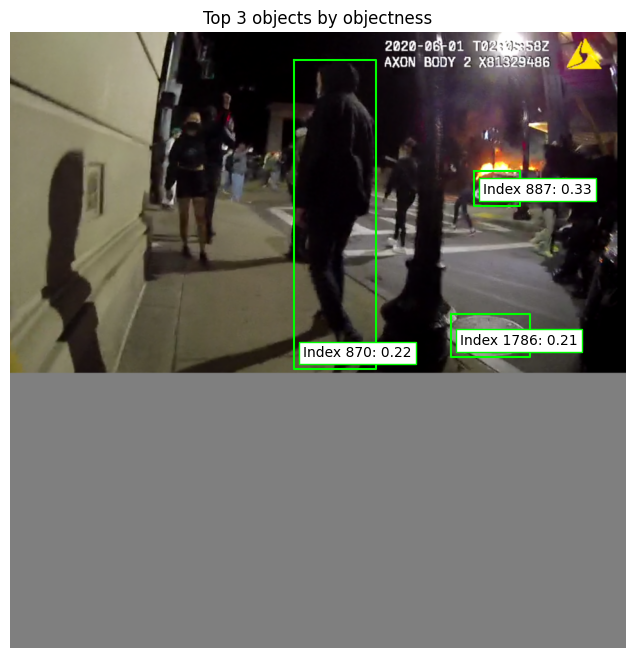

In [ ]:
# Remove batch dimension
objectnesses = np.array(objectnesses[0].detach())
source_boxes = np.array(source_boxes[0].detach())
source_class_embeddings = np.array(source_class_embeddings[0].detach())

# Let's show the top 3 patches
top_k = 3
objectnesses = sigmoid(objectnesses)
objectness_threshold = np.partition(objectnesses, -top_k)[-top_k]

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(unnormalized_source_image, extent=(0, 1, 1, 0))
ax.set_axis_off()

for i, (box, objectness) in enumerate(zip(source_boxes, objectnesses)):
  if objectness < objectness_threshold:
    continue

  cx, cy, w, h = box
  ax.plot(
      [cx - w / 2, cx + w / 2, cx + w / 2, cx - w / 2, cx - w / 2],
      [cy - h / 2, cy - h / 2, cy + h / 2, cy + h / 2, cy - h / 2],
      color='lime',
  )

  print("Index:", i)
  print("Objectness:", objectness)

  ax.text(
      cx - w / 2 + 0.015,
      cy + h / 2 - 0.015,
      f'Index {i}: {objectness:1.2f}',
      ha='left',
      va='bottom',
      color='black',
      bbox={
          'facecolor': 'white',
          'edgecolor': 'lime',
          'boxstyle': 'square,pad=.3',
      },
  )

ax.set_xlim(0, 1)
ax.set_ylim(1, 0)
ax.set_title(f'Top {top_k} objects by objectness')

In this case, the patches with indices 384, 1700 and 1871 have the highest objectness value. We can now take the index of the patch that corresponds to the cat, and get its embedding:

In [ ]:
# Get the query embedding with the index of the selected object.
# We're using the cat:
query_object_index = 1700  # Index of the cat box above.
query_embedding = source_class_embeddings[query_object_index]

Sidenote: you could easily crop out this object as follows:

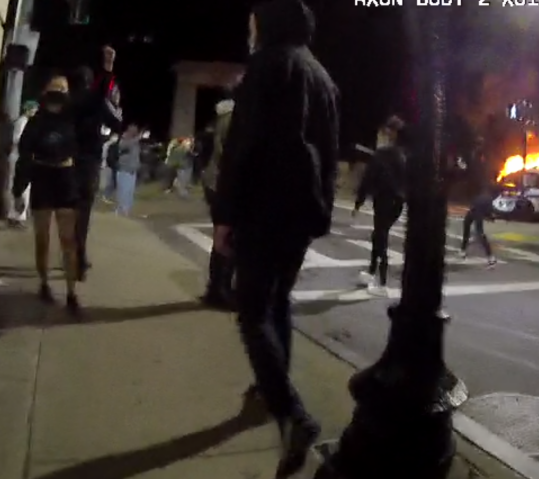

In [ ]:
from transformers.image_transforms import center_to_corners_format

img_w, img_h = unnormalized_source_image.size

# crop out cat from source image
box = source_boxes[query_object_index]
# convert from center_x, center_y, width, height to x1, x2, y1, y2
box = center_to_corners_format(box)
# rescale boxes to size of the source image
scale_fct = torch.tensor([img_w, img_h, img_w, img_h])
boxes = torch.tensor(box) * scale_fct
x1, y1, x2, y2 = tuple(boxes.tolist())
cropped_image = unnormalized_source_image.crop((x1, y1, x2, y2))
cropped_image

## Get predictions for target image with the query embedding

Now that we have a query embedding, we can condition the detection on this embedding. For that, we run our target image through OWLv2's vision encoder, and then condition the class embeddings on our query vector.

We can then take an argmax over the class logits to get the highest match.

Text(0.5, 1.0, 'Closest match')

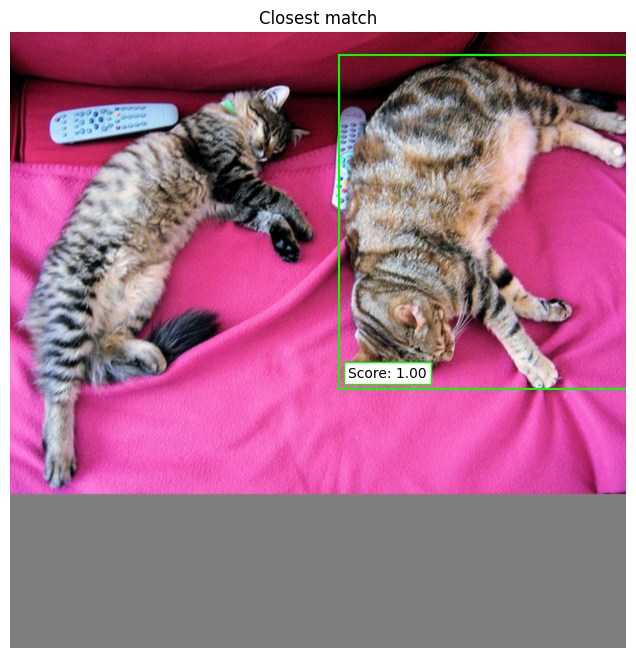

In [ ]:
# Process target image
target_pixel_values = processor(images=target_image, return_tensors="pt").pixel_values
unnormalized_target_image = get_preprocessed_image(target_pixel_values)

with torch.no_grad():
  feature_map = model.image_embedder(target_pixel_values)[0]

# Get boxes and class embeddings (the latter conditioned on query embedding)
b, h, w, d = feature_map.shape
target_boxes = model.box_predictor(
    feature_map.reshape(b, h * w, d), feature_map=feature_map
)

target_class_predictions = model.class_predictor(
    feature_map.reshape(b, h * w, d),
    torch.tensor(query_embedding[None, None, ...]),  # [batch, queries, d]
)[0]


# Remove batch dimension and convert to numpy:
target_boxes = np.array(target_boxes[0].detach())
target_logits = np.array(target_class_predictions[0].detach())

# Take the highest scoring logit
top_ind = np.argmax(target_logits[:, 0], axis=0)
score = sigmoid(target_logits[top_ind, 0])


fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(unnormalized_target_image, extent=(0, 1, 1, 0))
ax.set_axis_off()

# Get the corresponding bounding box
cx, cy, w, h = target_boxes[top_ind]
ax.plot(
    [cx - w / 2, cx + w / 2, cx + w / 2, cx - w / 2, cx - w / 2],
    [cy - h / 2, cy - h / 2, cy + h / 2, cy + h / 2, cy - h / 2],
    color='lime',
)

ax.text(
    cx - w / 2 + 0.015,
    cy + h / 2 - 0.015,
    f'Score: {score:1.2f}',
    ha='left',
    va='bottom',
    color='black',
    bbox={
        'facecolor': 'white',
        'edgecolor': 'lime',
        'boxstyle': 'square,pad=.3',
    },
)

ax.set_xlim(0, 1)
ax.set_ylim(1, 0)
ax.set_title(f'Closest match')

We could also visualize the second highest match (which ideally should correspond to the other cat). This is abstracted away in the `post_process_image_guided_detection` method of Owlv2Processor, which we'll demonstrate below.

## Use image_guided methods in Transformers

The Transformers library offers 2 methods to do what we've done above in fewer lines of code.

In [ ]:
# Process target and source image for the model
inputs = processor(images=target_image, query_images=source_image, return_tensors="pt")

# Print input names and shapes
for key, val in inputs.items():
    print(f"{key}: {val.shape}")

query_pixel_values: torch.Size([1, 3, 960, 960])
pixel_values: torch.Size([1, 3, 960, 960])


First off, we can use the `image_guided_detection` method to get the class logits conditioned on an embedding of the query. Note that this method leverages a heuristic which the authors developed for v1 to get the patch in the source image which most likely contains an object (it does not leverage the objectness logits).

In [ ]:
# Get predictions
with torch.no_grad():
  outputs = model.image_guided_detection(**inputs)

Next, we can pass the outputs to the `post_process_image_guided_detection` method, which takes in a score threshold (i.e., only get bounding boxes for the target image which have a score >= this value) as well as an NMS threshold (NMS is short for non-maximum suppression, a very popular method in object detection to remove duplicate bounding boxes). However here we specify NMS = 1.0 which means we don't need to do any NMS.

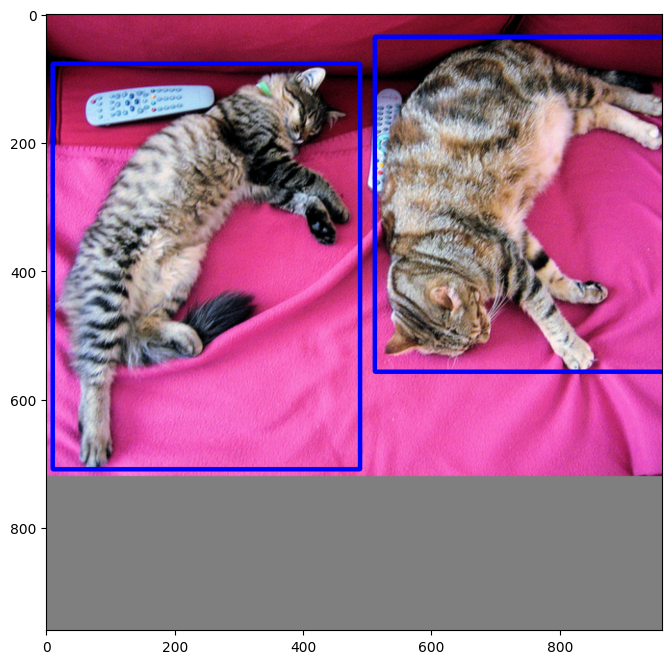

In [ ]:
img = cv2.cvtColor(np.array(unnormalized_target_image), cv2.COLOR_BGR2RGB)
outputs.logits = outputs.logits.cpu()
outputs.target_pred_boxes = outputs.target_pred_boxes.cpu()

target_sizes = torch.Tensor([unnormalized_image.size[::-1]])
# good values are 0.98, 0.95
results = processor.post_process_image_guided_detection(outputs=outputs, threshold=0.98, nms_threshold=1.0, target_sizes=target_sizes)
boxes, scores = results[0]["boxes"], results[0]["scores"]

# Draw predicted bounding boxes
for box, score in zip(boxes, scores):
    box = [int(i) for i in box.tolist()]

    img = cv2.rectangle(img, box[:2], box[2:], (255,0,0), 5)
    if box[3] + 25 > 768:
        y = box[3] - 10
    else:
        y = box[3] + 25

plt.imshow(img[:,:,::-1])